In [50]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [51]:
G = pickle.load(open('graphs/graph.pkl','rb'))

Edge Features

1) Product Group
2) Product Sub-Group
3) Plant
4) Storage Location

Node Features

1) Production
2) Factory Issue
3) Sales Order
4) Delivery to distributor

- 4 groups
- 12 subgroups
- 25 plants
- 13 storage locations

<h4>Product Groups and Sub-Groups<h4/>

In [52]:
product_groups = pd.read_csv('Raw Dataset/Homogenoeus/Nodes/Node Types (Product Group and Subgroup).csv')
product_groups.drop_duplicates(inplace=True)
product_groups.head()
removed_products = ['EEA200G24P','EEA500G12P','MAC1K25P','MAP1K25P','MAPA1K24P','ATPA1K24P','ATPPCH5X5K','POP015K',
                     'SO0005L04P','SO0002L09P',	'SO0001L12P','SO0500M24P']
product_groups = product_groups[[False if n in removed_products else True for n in product_groups['Node']]]

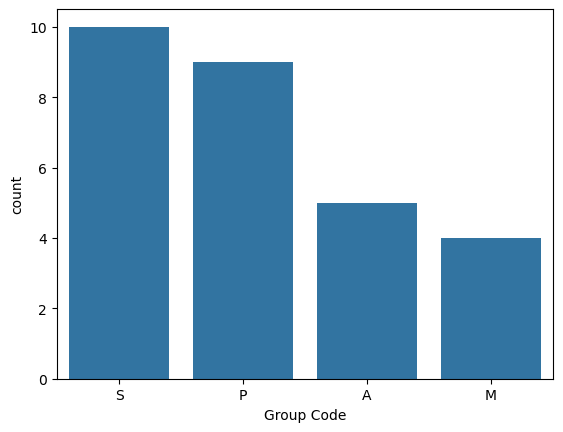

In [53]:
sns.barplot(product_groups['Group'].value_counts(),errorbar=('ci', False))
plt.xlabel('Group Code');

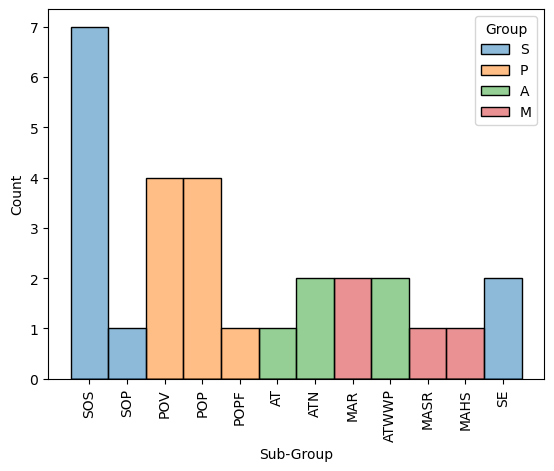

In [54]:
sns.histplot(product_groups,x='Sub-Group',hue='Group',)
plt.xticks(rotation=90);

<h4>Edge Demographics</h4>

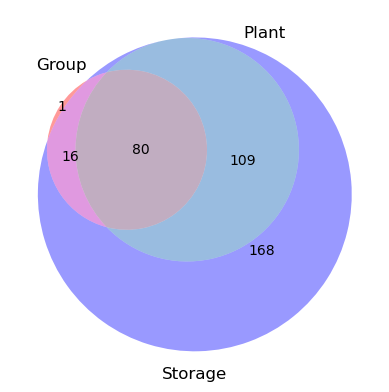

In [55]:
from matplotlib_venn import venn3
group_set = set([i for i,t in enumerate(G.edges(data=True))if t[2]['GroupCode'] > 0] )
subgroup_set = set([i for i,t in enumerate(G.edges(data=True))if t[2]['SubGroupCode'] > 0] )
plant_set = set([i for i,t in enumerate(G.edges(data=True))if t[2]['Plant'] > 0] )
storage_set = set([i for i,t in enumerate(G.edges(data=True))if t[2]['Storage Location'] > 0] )

venn3([group_set,plant_set,storage_set],['Group','Plant','Storage']);

- This venn diagram represents all 374 edges.
- every edge except one includes atleast one shared storage location. Surprisingly, that one edge is between products of the same group

In [56]:
edges_df = pd.DataFrame([
    [d['GroupCode'] for u,v,d in G.edges(data=True)],
    [d['Plant'] for u,v,d in G.edges(data=True)],
    [d['Storage Location'] for u,v,d in G.edges(data=True)],
],index=['GroupCode','Plant','Storage Location']).T

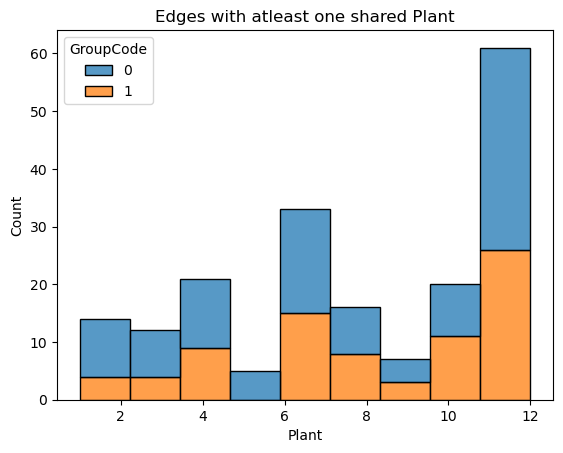

In [57]:
sns.histplot(data=edges_df[edges_df['Plant'] > 0],x='Plant',hue='GroupCode',multiple='stack')

plt.title('Edges with atleast one shared Plant');

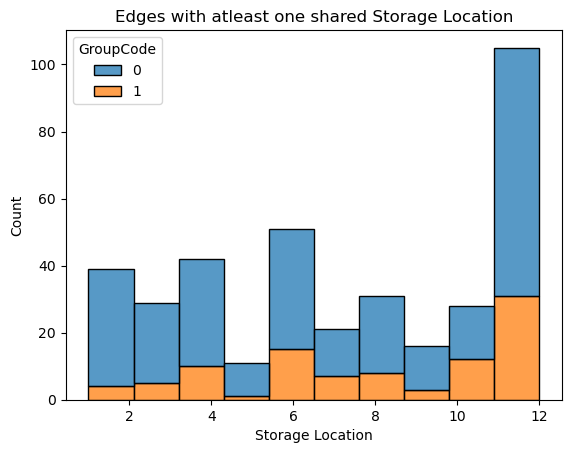

In [58]:
sns.histplot(data=edges_df[edges_df['Storage Location'] > 0],x='Storage Location',hue='GroupCode',multiple='stack')

plt.title('Edges with atleast one shared Storage Location');

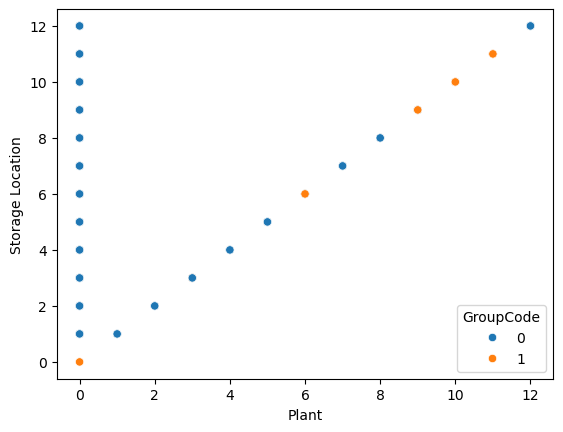

In [59]:
sns.scatterplot(data=edges_df,x='Plant',y='Storage Location',hue='GroupCode');

- Products that go to the same plants also go to the same storage locations which makes sense.
- It also looks like Storage Locations take products from different plants. some product(s) even share 12 storage locations without sharing a plant or group

<h4>Node Connectedness

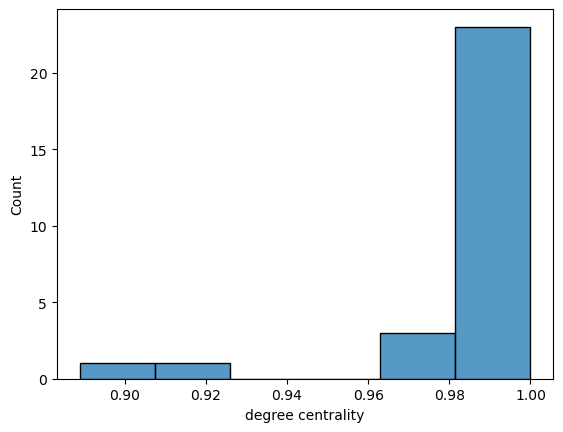

In [60]:
degree_cents = nx.degree_centrality(G)

sns.histplot(list(degree_cents.values()))
plt.xlabel('degree centrality');

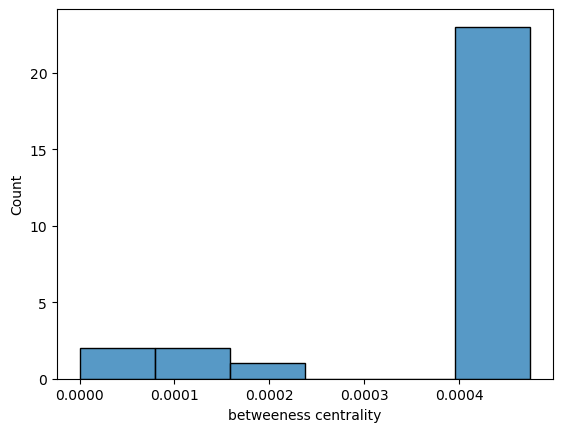

In [61]:
bet_cent = nx.betweenness_centrality(G)
sns.histplot(list(bet_cent.values()))
plt.xlabel('betweeness centrality');

The betweenness centrality is generally low, and degree centrality generally high, because almost every possible edge already exists. 28 choose 2 is 378 and there are 374 edges

<h4/>Plants and Storage Locations<h4/>

In [62]:
color_mapping = {     
    'S':'blue',
    'P':'orange',
    'A':'green',
    'M':'red',
}

for n in G.nodes():
    G.nodes.data()[n]['color'] = color_mapping[G.nodes.data()[n]['GroupCode']]

In [63]:
G_plants = nx.Graph()
G_plants.add_nodes_from(G.nodes(data=True))
G_plants.add_edges_from([(node1,node2,md) for node1,node2,md in G.edges(data=True) if md['Plant'] > 0])

In [84]:
G_storage = nx.Graph()
G_storage.add_nodes_from(G.nodes(data=True))
G_storage.add_edges_from([(node1,node2,md) for node1,node2,md in G.edges(data=True) if md['Storage Location'] > 11])
G_storage.remove_nodes_from([n for n in G.nodes() if G_storage.degree(n) == 0])

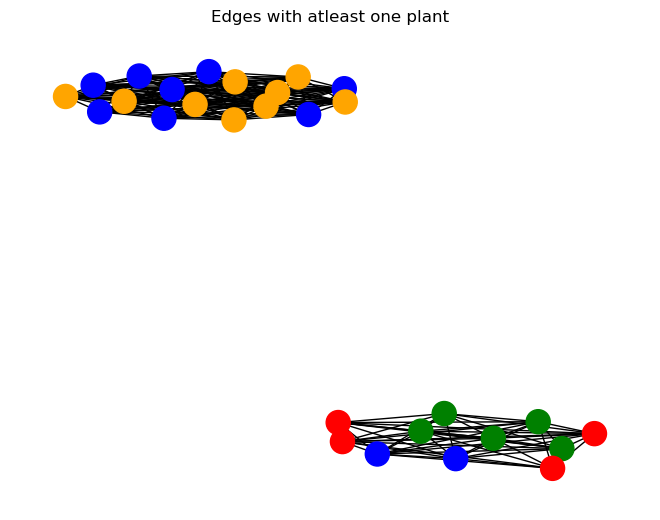

In [85]:
node_colors = nx.get_node_attributes(G_plants, "color").values()
colors = list(node_colors)

nx.draw(G_plants,node_color=colors)
plt.title('Edges with atleast one plant');

# product groups legend 
#     S: blue
#     P: orange
#     A: green
#     M: red

- It seems like like that groups M and A share plants while groups S and P share plants

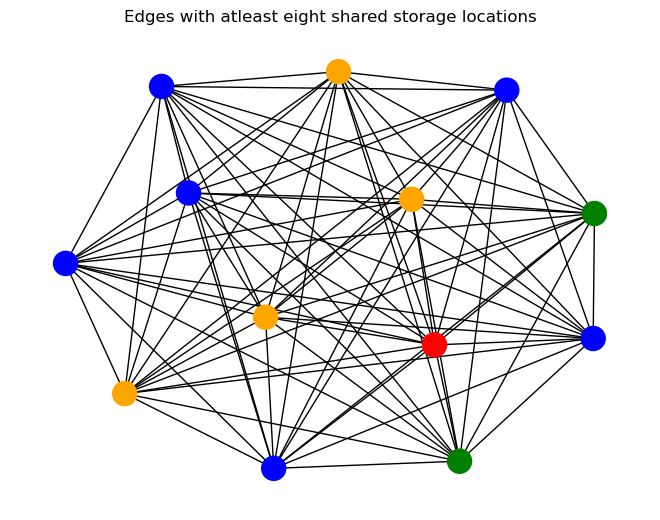

In [86]:
node_colors = nx.get_node_attributes(G_storage, "color").values()
colors = list(node_colors)

nx.draw(G_storage,node_color=colors)
plt.title('Edges with atleast eight shared storage locations');

# product groups legend 
#     S: blue
#     P: orange
#     A: green
#     M: red


<h4>Forecasting

In [66]:
d2d = pd.read_csv('Raw Dataset/Homogenoeus/Temporal Data/Weight/Delivery To distributor.csv').drop(removed_products,axis=1)
factory_issue = pd.read_csv('Raw Dataset/Homogenoeus/Temporal Data/Weight/Factory Issue.csv').drop(removed_products,axis=1)
production = pd.read_csv('Raw Dataset/Homogenoeus/Temporal Data/Weight/Production .csv').drop(removed_products,axis=1)
sales_orders = pd.read_csv('Raw Dataset/Homogenoeus/Temporal Data/Weight/Sales Order .csv').drop(removed_products,axis=1)

In [67]:
d2d.describe()

,SOS008L02P,SOS005L04P,SOS003L04P,SOS002L09P,SOS001L12P,SOS500M24P,SOS250M48P,SOP001L12P,POV005L04P,POV002L09P,...,ATN02K12P,ATN01K24P,MAR02K12P,MAR01K24P,ATWWP002K12P,ATWWP001K24P,MASR025K,MAHS025K,SE500G24P,SE200G24P
count,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,...,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000
mean,5.635529,124.753790,11.064377,76.834910,81.563465,31.173570,2.353013,0.971433,5.496565,8.964085,...,14.475631,69.101838,2.527719,16.588946,0.288036,1.019864,2.231448,0.644457,4.133623,0.283524
std,4.169567,69.370153,6.521028,43.612918,43.643968,16.154956,2.468839,1.456959,4.693937,6.600542,...,9.724836,40.896792,1.979340,9.151036,0.479131,1.097227,2.489258,1.168962,2.655927,0.291092
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.325760,74.635000,6.447360,45.241920,47.745229,18.271200,0.353291,0.066240,2.493400,4.193280,...,7.344000,38.740008,0.984000,10.224000,0.000000,0.072000,0.250000,0.000000,2.311500,0.072000
50%,5.174080,119.655200,10.532160,72.814320,80.399695,30.779520,1.700160,0.441600,4.022200,7.714980,...,12.840000,62.544000,2.328000,15.528000,0.048000,0.792000,1.500000,0.075000,3.828000,0.196800
75%,8.154880,164.072800,14.964720,103.301263,111.426720,41.576640,3.599040,1.269600,7.170800,11.957400,...,20.630008,93.289008,3.624000,22.008000,0.360000,1.536000,3.375000,0.625000,5.275998,0.408000
max,20.460800,340.712800,34.356480,228.325587,180.973189,74.221920,12.144232,9.495316,28.901600,30.548700,...,53.307984,189.000000,9.600000,44.832000,2.667984,6.159000,19.375000,6.150000,17.334000,1.521600


<Axes: >

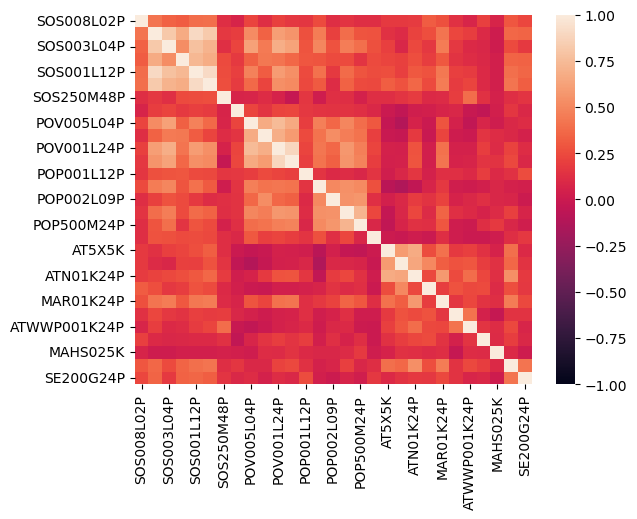

In [68]:
sns.heatmap(d2d.drop('Date',axis=1).corr(),vmin=-1,vmax=1)

<Axes: >

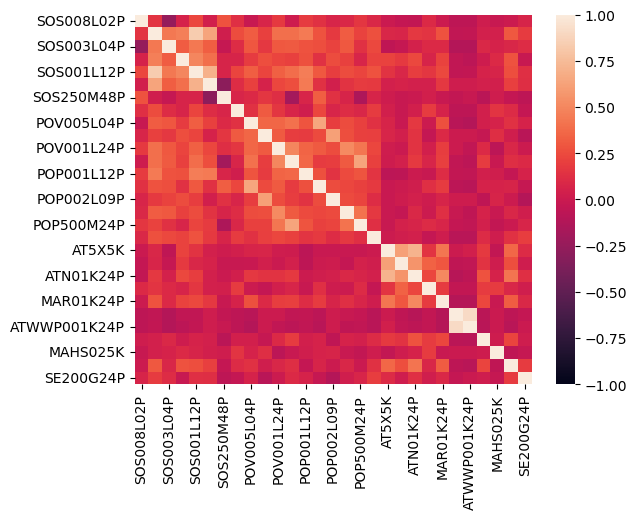

In [69]:
sns.heatmap(production.drop('Date',axis=1).corr(),vmin=-1,vmax=1)

<Axes: >

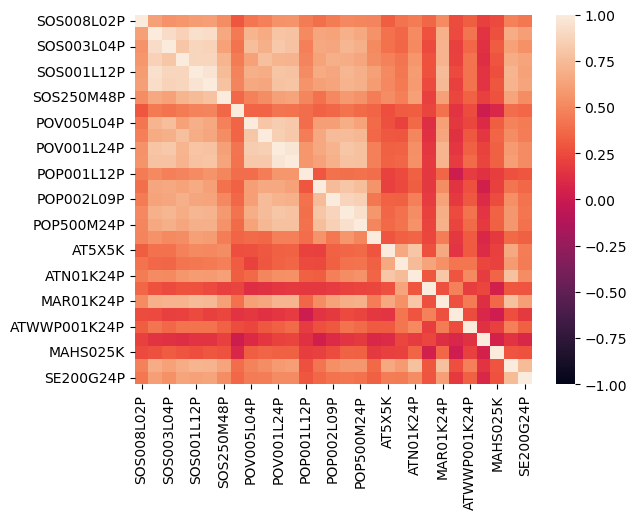

In [70]:
sns.heatmap(sales_orders.drop('Date',axis=1).corr(),vmin=-1,vmax=1)

<Axes: >

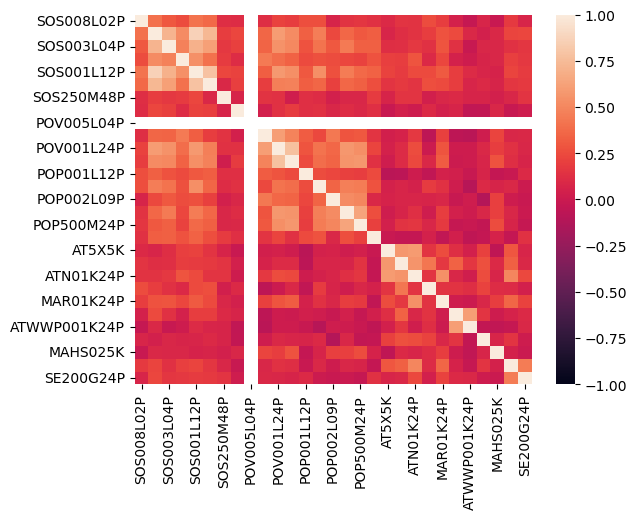

In [71]:
sns.heatmap(factory_issue.drop('Date',axis=1).corr(),vmin=-1,vmax=1) #the clear line  product had no factory issues